Importing libraries and our data file (Already filtered a bit using SQL Server).

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter

df = pd.read_csv(r'E:\Users\Colin\Documents\Data Science\Projects\FFLogs\DSR Damage Taken\DSRDamageTakenQueryResults.csv')

print(df.columns)

Index(['Source', 'ID', 'Target', 'Target Job', 'Action', 'Action Type',
       'Damage Taken', 'Damage Mitigated', 'Unmitigated Amount',
       'Damage Absorbed', 'Damage Blocked'],
      dtype='object')


Doing a bit of data cleaning and preprocessing. First off, let's take a look at who's taking damage in this fight.

In [166]:
df.Target.unique()

array(['Alastair Feuerkrone', 'Minako Saija', 'Nycto Smycto',
       'Charlotte Feuerkrone', 'Wrath Ocean', 'Caluriam Mentukal',
       'Worst Player', 'Death Asuran', 'Haurchefant'], dtype=object)

We've got nine targets in our 8-player raid which doesn't quite add up. In this case we only care about the damage that the players are taking, so while everyone loves our boy Haurchefant, unfortunately we'll have to filter him out.

In [167]:
df = df[df.Target != 'Haurchefant']
df.Target.unique()

array(['Alastair Feuerkrone', 'Minako Saija', 'Nycto Smycto',
       'Charlotte Feuerkrone', 'Wrath Ocean', 'Caluriam Mentukal',
       'Worst Player', 'Death Asuran'], dtype=object)

That's better. I also noticed that some of the damage columns had NaN values where damage wasn't taken, so we'll replace them with zeroes. Additionally, I'm going to elect to remove all instances of the Gunbreaker action "Superbolide", as it is self-inflicted damage when using the Gunbreaker's invulnerability and I'd rather it wasn't included in this case (for a graph later). And with that, we should be finished with our small amount of preprocessing.

In [168]:
df = df.fillna(0)
df = df[df.Action != 'Superbolide']

Now it's time to decide what kinds of questions we want to answer with this data. 
For starters, let's see how much damage each individual player took.

[Text(0, 0, '3,073,747'),
 Text(0, 0, '2,869,482'),
 Text(0, 0, '1,962,460'),
 Text(0, 0, '1,903,075'),
 Text(0, 0, '1,824,315'),
 Text(0, 0, '1,819,486'),
 Text(0, 0, '1,772,663'),
 Text(0, 0, '1,701,500')]

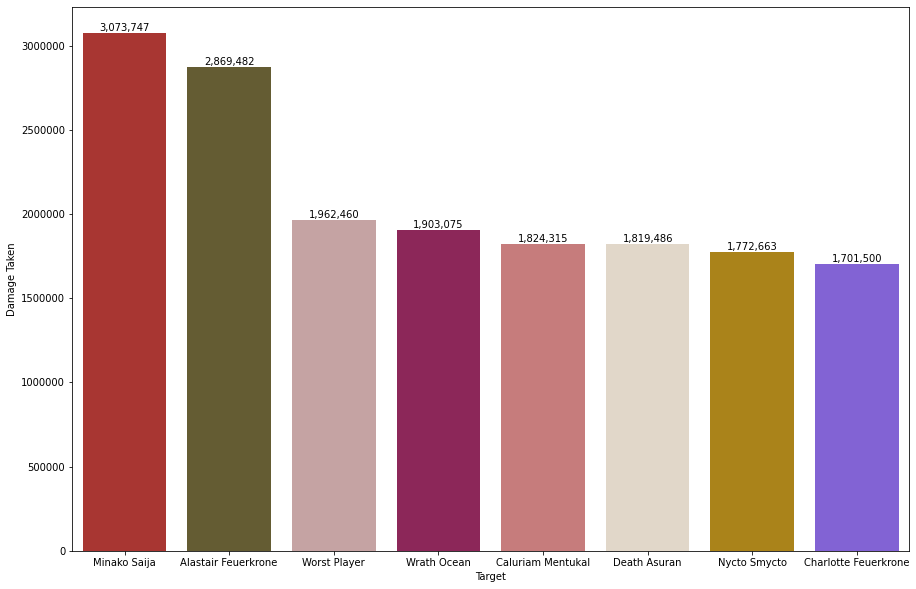

In [169]:
df_grouped = df[['Target','Damage Taken','Damage Mitigated','Unmitigated Amount','Damage Absorbed','Damage Blocked']].groupby(by=['Target']).sum().reset_index()
df_grouped = df_grouped.sort_values(by='Damage Taken', ascending = False)

plt.figure(figsize=(15, 10))
colors = ['#BB241F','#6C612B','#CB9E9D','#9D1659','#D27070','#E5D7C5','#C28E02','#7A50E7','#2189AA']
ax = sns.barplot(x='Target', y='Damage Taken', data=df_grouped, palette = colors)
container=ax.containers[0]
formatter = ticker.ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])

Here we see the amount of damage each player took throughout the fight (thank you, healers for your sacrifice). Unsurprisingly, we see our tanks in the first and second slot, followed by everyone else within a couple hundred thousand damage of each other. A couple hundred thousand damage seems like quite a bit, but when spread out over a fight that took 18:55 to complete, it doesn't average out to much.

In [170]:
A = df_grouped.loc[df_grouped['Target'] == 'Worst Player', 'Damage Taken'].item()
B = df_grouped.loc[df_grouped['Target'] == 'Charlotte Feuerkrone', 'Damage Taken'].item()
Damage = A - B

Time = 18*60+55
DamageOverTime = Damage / Time
print(DamageOverTime)

229.92070484581498


As we can see, over the very long duration of the fight, Worst Player only ended up taking roughly 230 more damage per second (DPS) than Charlotte Feuerkrone did.

Continuing to look into the data, I want to know what percentage of the total damage taken was a result of magic-based damage and what percentage was a result of physical-based damage.
This will prove to be a bit trickier, as our data doesn't necessarily say "Physical" or "Magical" on it, but there is one column that can help: "Action Type".

In [171]:
print(df['Action Type'].unique())

print(df[df['Action Type'] == 128].head(1))
print(df[df['Action Type'] == 1024].head(1))
print(df[df['Action Type'] == 32].head(1))
print(df[df['Action Type'] == 1].head(1))
print(df[df['Action Type'] == 64].head(1))
print(df[df['Action Type'] == 8].head(1))

[ 128 1024    1   64    8   32]
         Source   ID               Target  Target Job  Action  Action Type  \
0  King Thordan  171  Alastair Feuerkrone  Gunbreaker  attack          128   

   Damage Taken  Damage Mitigated  Unmitigated Amount  Damage Absorbed  \
0         23060            4069.0             33448.0           6319.0   

   Damage Blocked  
0          5185.0  
          Source   ID               Target  Target Job           Action  \
5  Ser Charibert  162  Alastair Feuerkrone  Gunbreaker  Lightning Storm   

   Action Type  Damage Taken  Damage Mitigated  Unmitigated Amount  \
5         1024         21330               0.0             26432.0   

   Damage Absorbed  Damage Blocked  
5           5102.0             0.0  
         Source   ID        Target Target Job     Action  Action Type  \
817  Hraesvelgr  209  Minako Saija    Warrior  Frostbite           32   

     Damage Taken  Damage Mitigated  Unmitigated Amount  Damage Absorbed  \
817          6323               0

With this information, we can determine that all Actions with Action Type value 128 are considered physical damage, all Actions with Action Type value 1024 are considered magic damage, and Actions with Action Type values of 1, 8, 32, and 64 can be grouped together as damage over time or "DoT" effects. (Note: If I didn't remove Superbolide from this list, it would appear in the list for Action Type value 32.)

([<matplotlib.patches.Wedge at 0x25937365280>,
 [Text(-0.7886040515546934, 0.7668791624966235, 'Magic'),
  Text(0.5232257468488867, -0.967592278717862, 'Physical'),
  Text(1.0496766211338264, -0.32890574796599964, 'DoT')],
 [Text(-0.43014766448437813, 0.41829772499815826, '12,770,293  (75.44)%'),
  Text(0.2853958619175745, -0.5277776065733792, '2,520,386  (14.89)%'),
  Text(0.5725508842548143, -0.17940313525418158, '1,636,049  (9.67)%')])

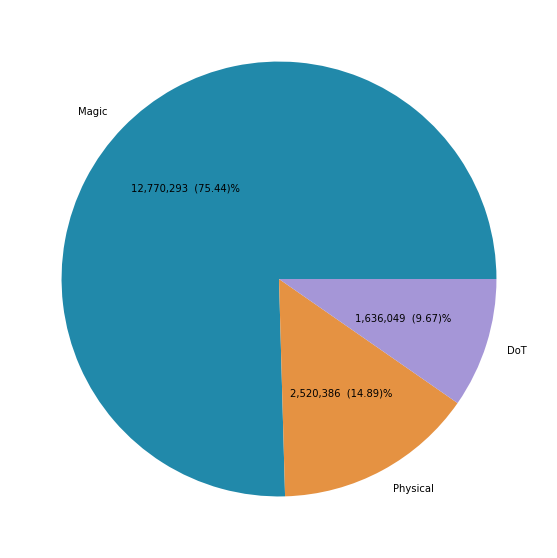

In [172]:
DoTList = [1, 8, 32, 64]

df.loc[df['Action Type'] == 128, 'Action Type'] = 'Physical'
df.loc[df['Action Type'] == 1024, 'Action Type'] = 'Magic'
df.loc[df['Action Type'].isin(DoTList), 'Action Type'] = 'DoT'

df_type = df.groupby(by='Action Type').sum().reset_index()
df_type = df_type.sort_values(by=['Damage Taken'], ascending=False).reset_index()

plt.figure(figsize=(15, 10))
colors = ['#2189AA','#E59242','#A596D7']
plt.pie(df_type['Damage Taken'], labels = df_type['Action Type'], colors = colors, autopct = lambda x: '{:,.0f}  ({:.2f})%'.format(x*df_type['Damage Taken'].sum()/100,x))

What we're seeing here is very common in Final Fantasy XIV encounters; a very large majority of the total "raidwide" damage taken is magic damage. What we can take away from this information is that actions that reduce magic damage taken are incredibly valuable in this encounter, as well as nearly all encounters.

It's very common for a large amount of physical damage taken to be exclusively taken by the tanks. We've got our total physical damage taken figure here, but I want to see what that figure looks like when we filter out the damage taken exclusively by the tanks. How much raidwide damage is actually physical?

([<matplotlib.patches.Wedge at 0x259379f6400>,
 [Text(-0.08826417587308041, 1.0964531158501243, 'Raid Damage'),
  Text(0.08826427853042887, -1.096453107586231, 'Tank Damage')],
 [Text(-0.04814409593077113, 0.5980653359182496, '1,324,636  (52.56)%'),
  Text(0.048144151925688466, -0.5980653314106714, '1,195,750  (47.44)%')])

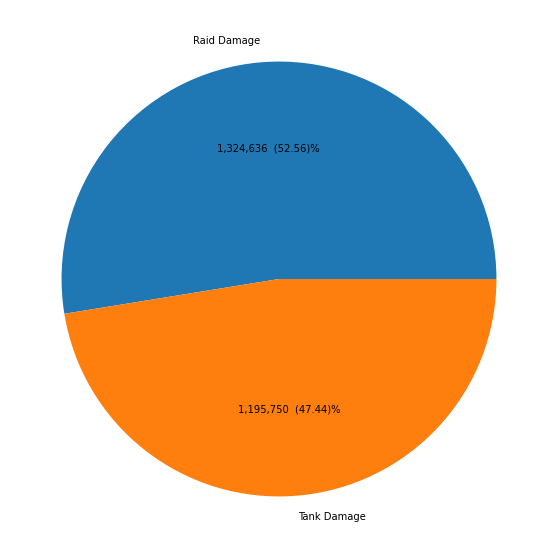

In [188]:
df_physical = df[['Target','Damage Taken','Action','Action Type']]
df_physical = df_physical.loc[df_physical['Action Type'] == 'Physical']

TankDamage = ['attack','Holy Bladedance','Holy Shield Bash','Heavenly Heel','Ascalon\'s Might','Wyrmclaw']
#This is a list of actions that exclusively target tanks.

df_physical.loc[df_physical['Action'].isin(TankDamage), 'Action Type'] = 'Tank Damage'
df_physical.loc[~df_physical['Action'].isin(TankDamage), 'Action Type'] = 'Raid Damage'

df_physical = df_physical.groupby(by='Action Type').sum().reset_index()
df_physical = df_physical.sort_values(by=['Damage Taken'], ascending=False).reset_index()

plt.figure(figsize=(15, 10))
plt.pie(df_physical['Damage Taken'], labels = df_physical['Action Type'], autopct = lambda x: '{:,.0f}  ({:.2f})%'.format(x*df_physical['Damage Taken'].sum()/100,x))

With a list of all the actions that exclusively damage tanks, we're able to note that nearly half of the physical damage taken is dealt exclusively to the two tanks. Note that tanks still take the raidwide damage, so some of this Raid Damage section of the chart still belongs to the tanks.

There's one last area I want to look into: damage mitigation. A critically important part of doing ultimate level raiding in Final Fantasy XIV is effective use of damage mitigation actions. "Damage mitigation" refers to any ability that reduces the damage a player takes by some amount. This results in an easier job for the healers, and in some cases, will allow the players to survive an attack that would normally result in deaths. 

Let's compare our unmitigated damage to our damage taken. Note: "unmitigated damage" in this case is a measure of the damage that would be taken by a player if no damage mitigation actions are used, and "damage taken" will refer to the actual damage that was taken.

Text(0, 0.5, '')

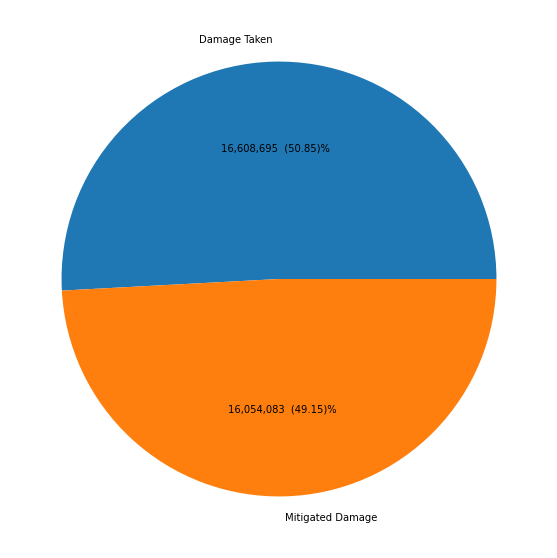

In [226]:
df_noEnrage = df[df.Action != 'Morn Afah\'s Edge']
#I'm removing this ability because it serves as the fight's "enrage" mechanic, designed to end the encounter if the boss is not defeated
#in a certain amount of time. This will add several 9,999,999 values to our Unmitigated Damage that will end up skewing the data.

df_mitigation = df_noEnrage[['Damage Taken','Unmitigated Amount']].sum()

A = df_mitigation.loc[df_mitigation.index == 'Damage Taken'].item()
B = df_mitigation.loc[df_mitigation.index == 'Unmitigated Amount'].item()
df_mitigation['Mitigated Damage'] = B - A
#df_mitigation = df_mitigation.reset_index(drop=True)
df_mitigation = df_mitigation.drop(['Unmitigated Amount'])

plt.figure(figsize=(15, 10))
plot = df_mitigation.plot.pie(y=df_mitigation.index, autopct = lambda x: '{:,.0f}  ({:.2f})%'.format(x*df_mitigation.sum()/100,x))
plot.set_ylabel('')

I'm very surprised by this one. I knew that damage mitigation was absurdly important, but I was unprepared to see just how much damage that my group avoided. This plot is showing me that my raid group was able to avoid roughly half of all damage taken throughout the fight just by being efficient with damage mitigation abilities. Use your cooldowns, folks!